In [3]:
import pandas as pd
from sqlalchemy import create_engine
from sqlalchemy.pool import NullPool
from config import config

SERVER = config['SERVER']
PORT = config['PORT']
DATABASE = config['DATABASE']
USERNAME = config['USERNAME']
PASSWORD = config['PASSWORD']

In [16]:
leads_estoque = """
SELECT 
	`distribuidos`.producer_id,
	`distribuidos`.`distribuidos`,
	`finalizados`.`finalizados`
FROM
( 
SELECT
	lead_producer.producer_id,
	COUNT(lead_producer.producer_id) AS `distribuidos`
FROM leads
INNER JOIN lead_producer
ON lead_producer.lead_id = leads.id AND lead_producer.campaign_id = 1
INNER JOIN producers
ON producers.id = lead_producer.producer_id AND producers.`type` = 'broker'
WHERE 
    leads.created_at >= '2020-10-01'
GROUP BY lead_producer.producer_id) AS `distribuidos`
INNER JOIN
(
SELECT
	lead_producer.producer_id,
	COUNT(lead_producer.producer_id) AS `finalizados`	
FROM leads
INNER JOIN lead_producer
ON lead_producer.lead_id = leads.id AND lead_producer.campaign_id = 1
INNER JOIN producers
ON producers.id = lead_producer.producer_id AND producers.`type` = 'broker'
WHERE 
	leads.status = 'done'
	AND leads.created_at >= '2021-01-01'
GROUP BY lead_producer.producer_id) AS `finalizados`
on finalizados.producer_id = distribuidos.producer_id"""

engine = create_engine(
        'mysql+mysqlconnector://' + USERNAME + ':' + PASSWORD + '@' + SERVER + ':25060/' + DATABASE,
        poolclass=NullPool)
conn = engine.connect()
df_leads_estoque = pd.read_sql(leads_estoque, conn)
conn.close()

data = df_leads_estoque.copy()

In [17]:
data

producer_id  distribuidos  finalizados
0       7269708           191           94
1      37004826           224           97
2       7090525           121           57
3      37005067           104           51
4       7269253           129           58
..          ...           ...          ...
231     7247309             5            1
232     7268645            18            2
233     7269862             8            3
234    27002818             1            1
235    37004536             2            1

[236 rows x 3 columns]

In [23]:
data['tx'] = data['finalizados'] / data['distribuidos']
data.sort_values('tx')

producer_id  distribuidos  finalizados        tx
150    37004361            58            1  0.017241
195     7269665           109            2  0.018349
223     7151426           100            2  0.020000
209     7267480            45            1  0.022222
181     7269108           154            4  0.025974
..          ...           ...          ...       ...
151    19019174             1            1  1.000000
199     7022050            21           21  1.000000
220     7269879             2            2  1.000000
187    37004870             3            3  1.000000
186     7266787             5            5  1.000000

[236 rows x 4 columns]

<AxesSubplot:>

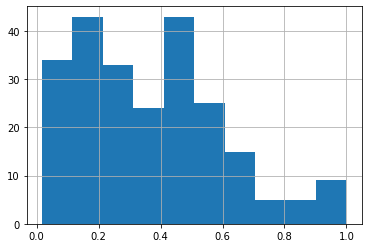

In [19]:
data['tx'].hist()